In [14]:
import numpy as np
import pandas as pd
import random
from random import sample
from IPython.display import clear_output
from matplotlib import pyplot as plt
from tqdm import tqdm

random.seed(0)

Initialize the sugarscape in the "classical" way.

In [15]:
def initialize_sugarscape(N):
    """
    Function to generate the "classical" sugarscape.
    
    Parameters
    ==========
    N : Side of the sugarscape lattice.
    """
    
    SuSca = np.zeros([N, N])
    X, Y = np.meshgrid(np.arange(N), np.arange(N))
    
    x_centers = np.array([N / 4, 3 * N / 4])
    y_centers = np.array([N / 4, 3 * N / 4])

    r_levels = np.array([4, 3, 2, 1]) / 4 * (np.sqrt(2) / 4) * N
    s_levels = np.array([1, 2, 3, 4])
    
    for k in range(np.size(x_centers)):
        d = np.sqrt((X - x_centers[k]) ** 2 +
                    (Y - y_centers[k]) ** 2)
        for i in range(np.size(s_levels)):
            region = np.where(d <= r_levels[i])
            SuSca[region[0], region[1]] = s_levels[i]
    
    return SuSca


Function to convert a 2 dimensional numpy array into a RGB image.

In [16]:
def convert2RBG(SuSca, RGB0, RGB1):
    """
    Function to convert the 2 dimensional numpy array into a RGB image.
    
    Parameters
    ==========
    game_outcome : Outcome of the prisoner's dilemma.
    RGB0 : Components R, G, B of the chosen color shade for minimum I_profile.
    RGB1 : Components R, G, B of the chosen color shade for maximum I_profile.
    """
    game_outcome = SuSca.copy()
    
    [n_rows, n_cols] = game_outcome.shape
    
    I_RGB = np.zeros([n_rows, n_cols, 3])
    
    # Set I_profile between 0 and 1
    game_outcome -= np.amin(game_outcome)    
    game_outcome /= 4 #np.amax(game_outcome)  
    
    for c in range(3):
        I_RGB[:, :, c] = game_outcome * RGB1[c] + (1 - game_outcome) * RGB0[c]

    return I_RGB

Check whether the initialization works.

In [17]:
def get_viewfield(xa, ya, va, Nx, Ny, Alive):
    rx = np.zeros(va * 4 + 1) + xa
    ry = np.zeros(va * 4 + 1) + ya

    # First position is the current agents
    rx[0] = xa
    ry[0] = ya
    
    # Covers all cardinal directions
    rx[0 * va + 1:1 * va + 1] = xa + np.arange(va) + 1
    rx[1 * va + 1:2 * va + 1] = xa - np.arange(va) - 1
    ry[2 * va + 1:3 * va + 1] = ya + np.arange(va) + 1
    ry[3 * va + 1:4 * va + 1] = ya - np.arange(va) - 1
    
    # Wrapping around boundaries
    rx = rx.astype(int) % Nx
    ry = ry.astype(int) % Ny

    A_view = list(zip(rx.tolist(), ry.tolist()))
    mask = [True]+[item not in Alive for item in A_view[1:]]
    indices = np.where(mask)[0] 
    A_view = np.array(A_view )

    rx, ry = zip(*A_view[indices])
    rx = list(rx)
    ry = list(ry)

    return rx, ry

In [18]:
def move_agents(SuSca, Agents):

    Nx,Ny = SuSca.shape
    nSuSca = SuSca.copy()

    # New_Agents = Agents.copy() 
    Alive_indices = np.where(Agents["Alive?"]==True)[0]

    Alive_x = Agents["X position"][Agents["Alive?"]].copy()
    Alive_y = Agents["Y position"][Agents["Alive?"]].copy()

    Alive = list(zip(Alive_x, Alive_y))

    # Define the order of the agents in this round.   
    order = np.random.permutation(Alive_indices)
    x = np.array(Agents["X position"].copy())
    y = np.array(Agents["Y position"].copy())
    v = np.array(Agents["Vision"].copy())
    s = np.array(Agents["Sugar"].copy())
    m = np.array(Agents["Metabolism"].copy())
    a = np.array(Agents["Alive?"].copy())

    for ia in order:

        xa = x[ia]
        ya = y[ia]
        va = v[ia]

        rx, ry = get_viewfield(xa, ya, va, Nx, Ny, Alive)
        
        Sugar = nSuSca[ry, rx]
        max_sugar = int(np.amax(Sugar))
        pos = np.where(Sugar == max_sugar)[0][-1]

        x_ref = rx[pos] % Nx
        y_ref = ry[pos] % Ny

        x[ia] = x_ref
        y[ia] = y_ref
        s[ia] += nSuSca[y_ref,x_ref]
        s[ia] -= m[ia]
        nSuSca[y_ref,x_ref] = 0

        not_alive = np.where(s <= 0)[0]
        a[not_alive] = False

    Agents["X position"] = x
    Agents["Y position"] = y
    Agents["Vision"] = v
    Agents["Sugar"] = s
    Agents["Metabolism"] = m
    Agents["Alive?"] = a


        
    return nSuSca, Agents



Now let's try without animation.

In [19]:
def generate_numbers(N_properties, tot_value ):

    agent = np.ones(N_properties)
    agent_vector = np.random.rand(N_properties)
    normalized_vector = np.round(agent_vector / np.sum(agent_vector) * (tot_value - N_properties)) + 1
    diff = tot_value - np.sum(normalized_vector)
    
    for _ in range(abs(int(diff))):
        if diff > 0:
            normalized_vector[np.argmin(normalized_vector)] += 1
        elif diff < 0:
            normalized_vector[np.argmax(normalized_vector)] -= 1
    return (normalized_vector.astype(int))

In [20]:
def mutation(Agents, i_agent, mutation_rate, properties): # Swap two features with a chance of mutation rate
    if np.random.rand() < mutation_rate:
        p = properties + 1
        i = random.randint(2, p)
        j = random.randint(2, p)
        
        while i == j:
            j = random.randint(2, p)

        placeholder = Agents.iloc[i_agent, i]    
        Agents.iloc[i_agent, i] = Agents.iloc[i_agent, j] 
        Agents.iloc[i_agent, j] = placeholder
        

In [21]:
# Fitness might be amount of Sugar after a specific amount of turns? 


In [22]:
def select_parents(agents, num_parents):
    parents = []
    for _ in range(num_parents):
        selected = agents.sample(3)  # Select 3 random agents for the tournament
        parent = selected.loc[selected["Sugar"].idxmax()]  # Select the best one
        parents.append(parent)
    return pd.DataFrame(parents)

In [23]:
def crossover(parent1, parent2):
    crossover_point = np.random.randint(0, 3)  # Randomly choose a point (since there are 3 traits)
    
    child1 = parent1.copy()
    child2 = parent2.copy()

    # Swap the genes after the crossover point
    if crossover_point == 0:
        child1['Sugar'], child2['Sugar'] = parent2['Sugar'], parent1['Sugar']
    elif crossover_point == 1:
        child1['Metabolism'], child2['Metabolism'] = parent2['Metabolism'], parent1['Metabolism']
    elif crossover_point == 2:
        child1['Vision'], child2['Vision'] = parent2['Vision'], parent1['Vision']
    
    return child1, child2

In [24]:
N = 50  # Size of the sugarscape with the agents.
A = 4  # Number of agents on the sugarscape.
mutation_rate = 0.25

# Initial values. Chosen from the following flat distributions.
possible_m = np.arange(4) + 1  # Metabolic rate.
possible_v = np.arange(6) + 1  # Vision.
possible_s = np.arange(21) + 5  # Sugar.

# Define agents position. 
L = np.array(sample(range(N * N), A)).astype(int) 
x = L % N
y = ((L - x) / N).astype(int) 
# This way each agent occupy a different cell.


properties = 4
total_value = 15

data = {
    "X position": L % N,
    "Y position": ((L - x) / N).astype(int),
    "Metabolism": np.full(A, 0, dtype=int),
    "Vision": np.full(A, 0, dtype=int),
    "Property 3": np.full(A, 0, dtype=int),
    "Property 4": np.full(A, 0, dtype=int),
    "Sugar": np.random.randint(np.size(possible_s), size=A) + 5,
    "Alive?": np.full(A, True, dtype=bool)    
}

Agents = pd.DataFrame(data)

for i in tqdm(range(A)):

    Agent = generate_numbers(properties, total_value)
    Agents.loc[i, ["Metabolism", "Vision","Property 3", "Property 4"]] = list(Agent)

print(Agents)
Agents0 = Agents.copy()

SuSca = initialize_sugarscape(N)


100%|██████████| 4/4 [00:00<00:00, 363.59it/s]

   X position  Y position  Metabolism  Vision  Property 3  Property 4  Sugar  \
0          27          31           2       5           3           5     17   
1          22          34           2       6           2           5     21   
2          15           3           4       2           4           5     14   
3          10          21           6       3           3           3     17   

   Alive?  
0    True  
1    True  
2    True  
3    True  


In [25]:
selected_parents = select_parents(Agents, A)
print(selected_parents)

   X position  Y position  Metabolism  Vision  Property 3  Property 4  Sugar  \
1          22          34           2       6           2           5     21   
1          22          34           2       6           2           5     21   
1          22          34           2       6           2           5     21   
1          22          34           2       6           2           5     21   

   Alive?  
1    True  
1    True  
1    True  
1    True  


In [26]:
# # Does not work yet!

# data = {
#     "X position": L % N,
#     "Y position": ((L - x) / N).astype(int),
#     "Metabolism": np.full(A, 0, dtype=int),
#     "Vision": np.full(A, 0, dtype=int),
#     "Property 3": np.full(A, 0, dtype=int),
#     "Property 4": np.full(A, 0, dtype=int),
#     "Sugar": np.random.randint(np.size(possible_s), size=A) + 5,
#     "Alive?": np.full(A, True, dtype=bool)    
# }

# New_Agents = pd.DataFrame(data)

# for i in range(A-1):
#     c1,c2 = crossover(selected_parents.iloc[i], selected_parents.iloc[i+1])
#     New_Agents.loc[i, ["Metabolism", "Vision", "Sugar"]] = c1.loc[["Metabolism", "Vision", "Sugar"]]
#     New_Agents.loc[i+1, ["Metabolism", "Vision", "Sugar"]] = c2.loc[["Metabolism", "Vision", "Sugar"]]


# print(New_Agents)
# print(New_Agents.iloc[5,0])

In [27]:
# mutation_rate = 0.25
# for i in range(A):
#     mutation(Agents, i, mutation_rate, properties)

# print(Agents)

In [28]:
# print(M, V, S)

# New Initialize agents
# data = {
#     "X position": L % N,
#     "Y position": ((L - x) / N).astype(int),
#     "Metabolism": np.random.randint(np.size(possible_m), size=A)+1,
#     "Vision": np.random.randint(np.size(possible_v), size=A) + 1,
#     "Sugar": np.random.randint(np.size(possible_s), size=A) + 5,
#     "Alive?": np.full(A, True, dtype=bool)    
# }

# Agents initialized. 
# data = {
#     "X position": L % N,
#     "Y position": ((L - x) / N).astype(int),
#     "Metabolism": 1,
#     "Vision": 3,
#     "Sugar": 5,
#     "Alive?": np.full(A, True, dtype=bool)    
# }

In [29]:
# RGB1 = [1.0, 0.5, 0.0]  # Orange. Color for high values.
# RGB0 = [1.0, 1.0, 1.0]  # White. Color for low values.



# Alive_agents = np.where(Agents["Alive?"]==True)[0]

# SuSca_RGB = convert2RBG(SuSca, RGB0, RGB1)

# plt.figure(figsize=(5, 5))
# plt.imshow(SuSca_RGB)
# plt.plot(Agents["X position"][Alive_agents], Agents["Y position"][Alive_agents], '.', color='k')
# plt.show()

# SuSca, Agents = move_agents(SuSca, Agents)

# SuSca_RGB = convert2RBG(SuSca, RGB0, RGB1)

# plt.figure(figsize=(5, 5))
# plt.imshow(SuSca_RGB)
# plt.plot(Agents["X position"][Alive_agents], Agents["Y position"][Alive_agents], '.', color='k')
# plt.show()

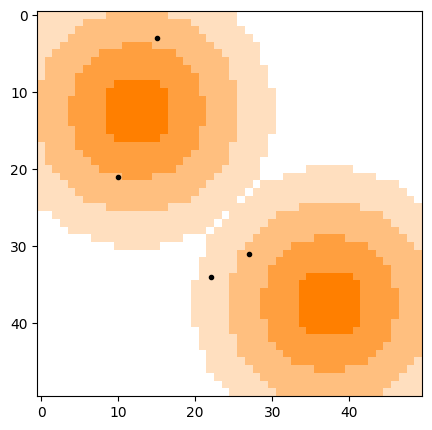

In [30]:
RGB1 = [1.0, 0.5, 0.0]  # Orange. Color for high values.
RGB0 = [1.0, 1.0, 1.0]  # White. Color for low values.

SuSca_RGB = convert2RBG(SuSca, RGB0, RGB1)
# print(SuSca)

plt.figure(figsize=(5, 5))
plt.imshow(SuSca_RGB)
plt.plot(Agents["X position"], Agents["Y position"], '.', color='k')
plt.show()

# print(Agents)

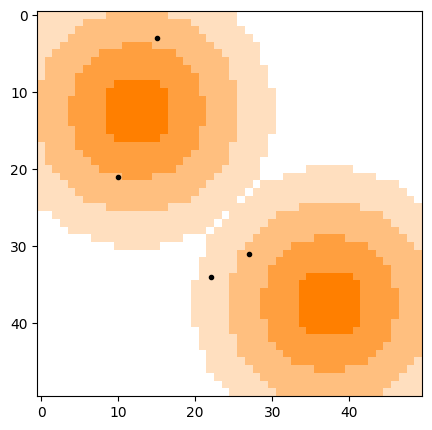

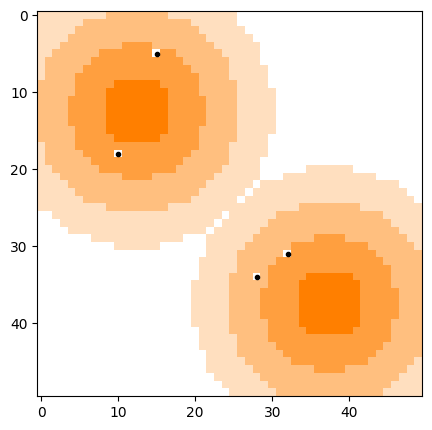

TypeError: select_parents() missing 1 required positional argument: 'num_parents'

In [31]:
SuSca_RGB = convert2RBG(SuSca, RGB0, RGB1)
# print(SuSca)

plt.figure(figsize=(5, 5))
plt.imshow(SuSca_RGB)
plt.plot(Agents["X position"], Agents["Y position"], '.', color='k')
plt.show()


    
# Create the image of the game outcome.
RGB1 = [1.0, 0.5, 0.0]  # Orange. Color for high values.
RGB0 = [1.0, 1.0, 1.0]  # White. Color for low values.

MAX_STEP = 1001
N_skip = 100
step = 0

N_alive_agents = np.zeros(MAX_STEP)

running = True  # Flag to control the loop.
while running:
    
    N_alive_agents[step] = Agents["Alive?"].sum()

    nSuSca, Agents= move_agents(SuSca, Agents) # A, V, S, M, x, y   nA, nV, nS, nM, nx, ny
    # print(nSuSca)
    if step % N_skip == 0:  
        # print(Agents) 
        SuSca_RGB = convert2RBG(nSuSca, RGB0, RGB1)

        plt.figure(figsize=(5, 5))
        plt.imshow(SuSca_RGB)
        plt.plot(Agents["X position"][Agents["Alive?"]], Agents["Y position"][Agents["Alive?"]], '.', color='k')
        plt.show()


    step += 1

    if step % 20 == 0:
        New_Agents = Agents.copy()

        select_parents(New_Agents)
        
            
    if step >= MAX_STEP:
        running = False


Agents1 = Agents.copy()



Compare histograms:

In [ ]:
print(A)

400


#### Metabolism

In [ ]:
# Metabolism: initial and final distribution.
m_bins = possible_m
m_bins_edges = np.arange(np.amin(possible_m) - 0.5, np.amax(possible_m) + 0.6)
m_ini_h, m_ini_e = np.histogram(M0, bins=m_bins_edges)
m_fin_h, m_fin_e = np.histogram(M1, bins=m_bins_edges)


plt.figure(figsize=(10, 5))
plt.bar(m_bins, m_ini_h, width=0.8, edgecolor='k', label='initial')
plt.bar(m_bins, m_fin_h, width=0.4, edgecolor='k', label='final')
plt.legend()
plt.xlabel('m')
plt.title('Metabolism')
plt.show()





NameError: name 'M0' is not defined

#### Vision

In [ ]:
# Vision: initial and final distribution.
v_bins = possible_v
v_bins_edges = np.arange(np.amin(possible_v) - 0.5, np.amax(possible_v) + 0.6)
v_ini_h, v_ini_e = np.histogram(V0, bins=v_bins_edges)
v_fin_h, v_fin_e = np.histogram(V1, bins=v_bins_edges)


plt.figure(figsize=(10, 5))
plt.bar(v_bins, v_ini_h, width=0.8, edgecolor='k', label='initial')
plt.bar(v_bins, v_fin_h, width=0.4, edgecolor='k', label='final')
plt.legend()
plt.xlabel('v')
plt.title('Vision')
plt.show()


#### Sugar

In [ ]:
# Sugar: initial and final distribution.
s_bins_i = possible_s
s_bins_edges_i = np.arange(np.amin(possible_s) - 0.5, np.amax(possible_s) + 0.6)
s_ini_h, s_ini_e = np.histogram(S0, bins=s_bins_edges_i)

plt.figure(figsize=(10, 5))
plt.bar(s_bins_i, s_ini_h, width=0.8, edgecolor='k', label='initial')
plt.legend()
plt.xlabel('s')
plt.title('sugar')
plt.show()




### Lorenz curve and Gini coefficient.

Measure of equality in wealth / resources distribution 

In [ ]:
def Lorenz_curve(s):
    """
    Function to generate the Lorenz curve from a sequence of data.
    
    Parameters
    ==========
    s : Sugar of each agent.
    """
    
    N = np.size(s)
    
    population_fraction = np.arange(N) / N
    
    s_sorted = np.sort(s)
    
    cumulative_s_fraction = np.cumsum(s_sorted) / np.sum(s_sorted)
    
    
    return cumulative_s_fraction, population_fraction

In [ ]:
L0, F0 = Lorenz_curve(S0)


plt.figure(figsize=(5, 5))
plt.plot(F0, L0, '.-', label='initial')
plt.plot([0, 1], [0, 1], '--', color='k', label='equality')
plt.legend()
plt.xlabel('F')
plt.ylabel('L')
plt.title('sugar')
plt.show()


